# Import library

In [143]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import math

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, TargetEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score

In [144]:
pd.set_option('display.max_columns', None)               # Hiển thị đầy đủ bảng với thanh trượt ngang
pd.set_option('display.float_format', '{:,.2f}'.format)  # Làm tròn số hiển thị ở dạng 2 thập phân cho gọn
pd.set_option('future.no_silent_downcasting', True)   

# Data Preprocessing

In [145]:
# Excel gốc bị trống dòng đầu tiên, lấy dòng 2 và 3 làm header
data_raw = pd.read_excel(r"C:\Users\ta an\Desktop\Fox_AI\KPI_for_Bank_FoxAI\KPI 2024.xlsx", header=[1,2])
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14074 entries, 0 to 14073
Data columns (total 41 columns):
 #   Column                                                Non-Null Count  Dtype         
---  ------                                                --------------  -----         
 0   (Unnamed: 0_level_0, Tháng)                           14074 non-null  float64       
 1   (Unnamed: 1_level_0, CIF CBNV)                        14074 non-null  object        
 2   (Unnamed: 2_level_0, Họ - Tên CBNV)                   14074 non-null  object        
 3   (Unnamed: 3_level_0, Mã ĐVKD)                         14074 non-null  int64         
 4   (Unnamed: 4_level_0, Khu vực)                         14074 non-null  object        
 5   (Unnamed: 5_level_0, Tên đơn vị)                      14074 non-null  object        
 6   (Unnamed: 6_level_0, Chức danh)                       14074 non-null  object        
 7   (Unnamed: 7_level_0, Mã chức danh)                    14074 non-null  object

In [146]:
# Tạo cột mới bao gồm các header muốn thay - dạng list (Đối chiếu với file excel cho dễ nhìn)
new_header = ['Tháng', 'CIF CBNV', 'Họ Tên', 
              'Mã ĐVKD', 'Khu vực', 'Đơn vị', 'Chức danh', 'Mã chức danh',     
              'Ngày vào làm việc', 'Giới tính', 'Năm sinh',                   
              'Book Huy động', 'Book Cho vay', 'Net Huy động', 'Net Cho vay',
              'Điểm Book TỔNG HĐ chưa chặn', 'Điểm Book HĐ KỲ HẠN chưa chặn', 'Điểm Book HĐ CASA chưa chặn', 'Điểm Book CV chưa chặn',
              'Điểm Net HĐ', 'Điểm Net CV', 
              'SL KH',
              'KPI_CN Book Value', 'KPI_CN Net Value', 'KPI_CN Điểm DV', 'KPI_CN CLTD/DV',
              'KPI_BP Book Value', 'KPI_BP Net Value', 'KPI_BP Điểm DV', 'KPI_BP CLTD/DV',
              'Tổng điểm CN', 'Tổng điểm BP', 
              'Điểm KH CN', 'Điểm KH BP', 
              'Tỷ trọng KPI_CN', 'Tỷ trọng KPI_BP',
              'Điểm Cộng/Trừ CN', 
              '% KPI_CN', '% KPI_BP', '% KPI cuối cùng', 
              'Thu nhập Gross'
             ]

# Ghi đè cột Header mới đủ 41 biến thay cho Header 1 và 2 MultiIndex, tạo thành dataframe 
data_raw.columns = new_header

# Đổi tên để lưu trữ
df_renamed = data_raw

# Kiểm tra 
display(df_renamed.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14074 entries, 0 to 14073
Data columns (total 41 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Tháng                          14074 non-null  float64       
 1   CIF CBNV                       14074 non-null  object        
 2   Họ Tên                         14074 non-null  object        
 3   Mã ĐVKD                        14074 non-null  int64         
 4   Khu vực                        14074 non-null  object        
 5   Đơn vị                         14074 non-null  object        
 6   Chức danh                      14074 non-null  object        
 7   Mã chức danh                   14074 non-null  object        
 8   Ngày vào làm việc              14074 non-null  datetime64[ns]
 9   Giới tính                      14074 non-null  object        
 10  Năm sinh                       14074 non-null  int64         
 11  Book Huy động  

None

In [147]:
# 0. Tháng                          Thời điểm dòng dữ liệu được ghi nhận vào hệ thống 
# 1. CIF CBNV                       Mã ID độc lập cho từng người, dùng để truy vấn nếu cần
# 2. Họ Tên
# 3. Mã ĐVKD             
# 4. Khu vực             
# 5. Đơn vị             
# 6. Chức danh           
# 7. Mã chức danh
# 8. Ngày vào làm việc
# 9. Giới tính
# 10. Năm sinh
# 11. Book Huy Động                 Tổng số tiền huy động được từ khách hàng     (tiền gửi, tiết kiệm, đầu tư)       >> Hiệu suất Thu hút vốn
# 12. Book Cho Vay                  Tổng số tiền đã giải ngân cho khách hàng vay                                     >> Hiệu suất Cho vay
# 13. Net Huy Động Vốn              = Book Huy Động Vốn - Số tiền khách rút ra   (Mức tăng trưởng của HĐV)           >> Hiệu suất thu hút tiền gừi
# 14. Net Cho Vay                   = Book Cho Vay - Số tiền khách trả nợ        (Mức tăng trưởng của Dư nợ cho vay) >> Hiệu suất tín dụng
# 15. Điểm Book Tổng HĐ chưa chặn   = f0(Book HĐ kỳ hạn, HĐ CASA, HĐ khác...)    (Cách tính tùy theo ngân hàng, hàm đã bị ẩn đi
# 16. Điểm Book HĐ kỳ hạn chưa chặn = f1(Book HĐ kỳ hạn)                          Cách tính tương tự, chỉ khác hàm: chia mức chuẩn, nhân hệ số,....) 
# 17. Điểm Book HĐ CASA chưa chặn   = f2(Book HĐ CASA)                                         
# 18. Điểm Book CV chưa chặn        = f3(Book CV)
# 19. Điểm Net HĐ                   = f4(Net HĐ)
# 20. Điểm Net CV                   = f5(Net CV)
# 21. SL KH
# 22. KPI_CN Book Value             = g0(Book HĐ, Book CV)                        Vẫn tương tự, hàm đã bị ẩn đi:
# 23. KPI_CN Net Value              = g1(Net HĐ, Net Value)                                     Thêm chặn, thay trọng số,... 
# 24. KPI_CN Điểm DV                Điểm Dư Vốn /// Điểm Dịch vụ ???????????                                   
# 25. KPI_CN CLTD/DV                Cho Lãi Tín Dụng / DV
# 26. KPI_BP Book Value                                                           Vẫn tương tự, hàm khác nữa bị ẩn đi:
# 27. KPI_BP Net Value                                                                          Chia cho tổng nào đó của bộ phận, thay trọng số,...    
# 28. KPI_BP Điểm DV                
# 29. KPI_BP CLTD/DV                       
# 30. Tổng điểm CN                  = SUM(22 23 24 25)
# 31. Tổng điểm BP                  = SUM(26 27 28 29)      
# 32. Điểm KH CN                    Điểm Kế hoạch Cá nhân
# 33. Điểm KH BP                    Điểm Kế hoạch Bộ phận
# 34. Tỷ trọng KPI_CN                    Tỷ trọng cột 34 35 để nhân với cột 37 38 ra cột 39        
# 35. Tỷ trọng KPI_BP                    Ví dụ: GDV tỷ trọng 1 - 0; Càng cấp cao như GĐ, KSV thì tỷ trọng 0.2 - 0.8 (chính sách ngân hàng tùy tháng)
# 36. Điểm Cộng/Trừ CN              Cộng vào cột 30 ???
# 37. % KPI_CN                      = 30 / 32
# 38. % KPI_BP                      = 31 / 33 
# 39. % KPI cuối cùng               = 30 * 37 + 35 * 38
# 40. Thu nhập Gross                Thu nhập trước khi trừ đi các khoản chi phí, thuế, bảo hiểm, v.v khác

In [148]:
# Tạo bản sao dataframe gọn, tránh ghi đè
df = df_renamed.copy()

# Xóa
df.drop(columns=['CIF CBNV', 'Họ Tên'], inplace=True)
df.drop(columns=['Khu vực'], inplace=True)

# Xem số Biến độc lập kết hợp với FILTER Excel
unique_counts = df_renamed[['Mã ĐVKD', 'Khu vực', 'Đơn vị', 'Chức danh', 'Mã chức danh']].nunique()
display(unique_counts)

# Xóa
df.drop(columns=['Đơn vị', 'Chức danh'], inplace=True)

Mã ĐVKD         134
Khu vực           8
Đơn vị          270
Chức danh        41
Mã chức danh      6
dtype: int64

In [149]:
# Tách năm và tháng từ các biến cũ
year_recorded = df['Tháng'].astype(int)
month_recorded = ((df['Tháng'] - year_recorded) * 100).round().astype(int)
year_joined = df['Ngày vào làm việc'].dt.year
month_joined = df['Ngày vào làm việc'].dt.month

# Tính 'Số năm đã làm', với phần thập phân biểu thị số tháng
years_worked = (year_recorded - year_joined) + (month_recorded - month_joined) / 12

# Thêm vào dataframe ở đúng vị trí index mong muốn
df.insert(3, 'Số năm đã làm', years_worked)

# Những trường hợp <0 coi như = 0
df['Số năm đã làm'] = df['Số năm đã làm'].apply(lambda x: max(x, 0))

# Kiểm tra
display(df[['Tháng', 'Ngày vào làm việc', 'Số năm đã làm']].head())

# Xóa các biến cũ
df.drop(columns=['Tháng', 'Ngày vào làm việc'], inplace=True)

,Tháng,Ngày vào làm việc,Số năm đã làm
0,"2,024.04",2008-06-17,15.83
1,"2,024.04",2010-12-15,13.33
2,"2,024.04",2008-02-01,16.17
3,"2,024.04",2010-08-11,13.67
4,"2,024.04",2008-09-04,15.58


In [150]:
# Trong quá trình làm, phát hiện duy nhất 2 quan sát bị sai năm sinh 2002 thành 2022 khiến Tuổi = 3
df.loc[df['Năm sinh'] == 2022, 'Năm sinh'] = 2002  # Sửa lỗi nhập liệu

# Tính 'Tuổi'
age = 2025 - df['Năm sinh']

# Thêm vào dataframe ở đúng vị trí index mong muốn
df.insert(4, 'Tuổi', age)

# Kiểm tra
display(df[['Năm sinh', 'Tuổi']].head())

# Xóa cột 'Năm sinh' sau khi đã tính tuổi
df.drop(columns=['Năm sinh'], inplace=True)

,Năm sinh,Tuổi
0,1983,42
1,1988,37
2,1977,48
3,1986,39
4,1982,43


In [151]:
df

,Mã ĐVKD,Mã chức danh,Số năm đã làm,Giới tính,Tuổi,Book Huy động,Book Cho vay,Net Huy động,Net Cho vay,Điểm Book TỔNG HĐ chưa chặn,Điểm Book HĐ KỲ HẠN chưa chặn,Điểm Book HĐ CASA chưa chặn,Điểm Book CV chưa chặn,Điểm Net HĐ,Điểm Net CV,SL KH,KPI_CN Book Value,KPI_CN Net Value,KPI_CN Điểm DV,KPI_CN CLTD/DV,KPI_BP Book Value,KPI_BP Net Value,KPI_BP Điểm DV,KPI_BP CLTD/DV,Tổng điểm CN,Tổng điểm BP,Điểm KH CN,Điểm KH BP,Tỷ trọng KPI_CN,Tỷ trọng KPI_BP,Điểm Cộng/Trừ CN,% KPI_CN,% KPI_BP,% KPI cuối cùng,Thu nhập Gross
0,25,CQL DVKH,15.83,Nữ,42,"68,382,348,762.00","853,800,000.00","3,127,777,986.33","-385,670,000.00",56.20,55.08,1.12,1.75,2.57,-0.79,20,29.04,0.64,2.93,-5.00,294.96,7.23,16.74,-30.00,27.60,288.93,131.33,413.17,0.60,0.40,NaN,0.21,0.70,0.41,"20,523,350.00"
1,22,CQL DVKH,13.33,Nữ,37,"68,382,348,762.00","853,800,000.00","3,127,777,986.33","-385,670,000.00",56.20,55.08,1.12,1.75,2.57,-0.79,548,57.95,1.77,7.70,0.00,182.44,1.54,16.12,0.00,67.42,200.11,131.33,589.08,0.60,0.40,NaN,0.51,0.34,0.44,"20,523,350.00"
2,27,CQL DVKH,16.17,Nam,48,"48,507,770,815.00","3,221,763.90","39,407,406,889.80","220,561.35",39.87,39.07,0.80,0.01,31.77,0.00,55,39.88,31.77,2.30,0.00,"1,503.13",147.45,152.33,0.00,73.95,"1,802.91",131.33,690.83,0.60,0.40,NaN,0.56,1.50,0.94,"26,886,939.00"
3,63,CQL DVKH,13.67,Nữ,39,"190,979,972,081.00","58,500,584.40","624,766,772.27","244,910,229.69",156.97,153.83,3.14,0.12,0.51,0.50,105,157.09,1.02,6.01,0.00,569.09,-6.06,46.63,0.00,112.09,609.67,131.33,720.00,0.60,0.40,NaN,0.85,0.85,0.85,"25,903,249.00"
4,31,CQL DVKH,15.58,Nữ,43,"56,215,318,133.00","390,000,000.00","1,898,063,539.63","46,200,000.00",46.20,45.28,0.92,0.80,1.56,0.09,86,47.00,1.65,50.93,-3.00,282.43,-2.48,3.95,-21.00,110.05,262.90,131.33,530.00,0.60,0.40,NaN,0.84,0.50,0.70,"22,537,911.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14069,7,CQL QHKH,0.00,Nam,38,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,0.00,0.00,"1,276.52",-19.16,77.36,1.20,0.00,"1,335.92",0.00,"1,291.93",0.60,0.40,0.00,0.00,1.03,0.41,NaN
14070,7,QLKH,0.00,Nam,27,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,NaN
14071,138,QLKH,0.00,Nữ,24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,NaN
14072,127,QLKH,0.00,Nam,26,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,NaN


# Divide dataframe according role

In [152]:
# DataFrame nhân viên (nv): KPI_CN = 1, KPI_BP = 0
dataframe_nv = df[(df['Tỷ trọng KPI_CN'] == 1.0) & (df['Tỷ trọng KPI_BP'] == 0.0)]
dataframe_nv = dataframe_nv.copy()

# DataFrame quản lý (ql): KPI_CN = 0.6, KPI_BP = 0.4
dataframe_ql = df[(df['Tỷ trọng KPI_CN'] == 0.6) & (df['Tỷ trọng KPI_BP'] == 0.4)]
dataframe_ql = dataframe_ql.copy()

# DataFrame lãnh đạo (ld): KPI_CN = 0.2, KPI_BP = 0.8
dataframe_ld = df[(df['Tỷ trọng KPI_CN'] == 0.2) & (df['Tỷ trọng KPI_BP'] == 0.8)]
dataframe_ld = dataframe_ld.copy()

# Draw Confusion matrix

# Dataframe_nv confusion matrix

In [153]:
dataframe_nv

,Mã ĐVKD,Mã chức danh,Số năm đã làm,Giới tính,Tuổi,Book Huy động,Book Cho vay,Net Huy động,Net Cho vay,Điểm Book TỔNG HĐ chưa chặn,Điểm Book HĐ KỲ HẠN chưa chặn,Điểm Book HĐ CASA chưa chặn,Điểm Book CV chưa chặn,Điểm Net HĐ,Điểm Net CV,SL KH,KPI_CN Book Value,KPI_CN Net Value,KPI_CN Điểm DV,KPI_CN CLTD/DV,KPI_BP Book Value,KPI_BP Net Value,KPI_BP Điểm DV,KPI_BP CLTD/DV,Tổng điểm CN,Tổng điểm BP,Điểm KH CN,Điểm KH BP,Tỷ trọng KPI_CN,Tỷ trọng KPI_BP,Điểm Cộng/Trừ CN,% KPI_CN,% KPI_BP,% KPI cuối cùng,Thu nhập Gross
26,73,GDV,0.83,Nữ,35,"16,717,578,022.00","244,503,887.70","95,054,078.80","249,622.41",13.74,13.47,0.27,0.50,0.08,0.00,401,14.24,0.08,1.40,-3.00,0.00,0.00,0.00,0.00,12.72,0.00,85.50,0.00,1.00,0.00,NaN,0.15,0.00,0.15,"7,662,000.00"
27,73,GDV,0.83,Nữ,27,"16,387,470,376.00","373,698,618.00","-1,227,723,201.93","1,239,023.30",13.47,13.20,0.27,0.77,-1.01,0.00,368,14.24,-1.01,2.12,-3.00,0.00,0.00,0.00,0.00,12.36,0.00,85.50,0.00,1.00,0.00,NaN,0.14,0.00,0.14,"7,962,000.00"
28,8,GDV,1.50,Nữ,25,"47,602,167,040.00","669,495,807.30","585,632,659.93","-88,476,816.41",39.13,38.35,0.78,1.38,0.48,-0.18,821,40.51,0.30,3.18,-3.00,0.00,0.00,0.00,0.00,40.99,0.00,85.50,0.00,1.00,0.00,NaN,0.48,0.00,0.48,"8,114,009.00"
29,8,GDV,1.17,Nữ,26,"13,515,104,731.47","5,729,358.90","866,064,389.83","52,101,849.02",11.11,10.89,0.22,0.01,0.71,0.11,206,11.12,0.82,0.40,-3.00,0.00,0.00,0.00,0.00,9.34,0.00,85.50,0.00,1.00,0.00,NaN,0.11,0.00,0.11,"7,825,350.00"
30,8,GDV,1.08,Nữ,28,"13,799,345,850.00","6,000,000.00","505,271,591.73",0.00,11.34,11.11,0.23,0.01,0.42,0.00,361,11.35,0.42,3.30,-3.00,0.00,0.00,0.00,0.00,12.07,0.00,85.50,0.00,1.00,0.00,NaN,0.14,0.00,0.14,"7,937,500.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14067,27,QLKH,0.00,Nữ,35,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,"972,080.00"
14070,7,QLKH,0.00,Nam,27,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,NaN
14071,138,QLKH,0.00,Nữ,24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,NaN
14072,127,QLKH,0.00,Nam,26,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,NaN


# Delete rows with non-salary

In [154]:
dataframe_nv = dataframe_nv.dropna(subset=['Thu nhập Gross'])
dataframe_nv

,Mã ĐVKD,Mã chức danh,Số năm đã làm,Giới tính,Tuổi,Book Huy động,Book Cho vay,Net Huy động,Net Cho vay,Điểm Book TỔNG HĐ chưa chặn,Điểm Book HĐ KỲ HẠN chưa chặn,Điểm Book HĐ CASA chưa chặn,Điểm Book CV chưa chặn,Điểm Net HĐ,Điểm Net CV,SL KH,KPI_CN Book Value,KPI_CN Net Value,KPI_CN Điểm DV,KPI_CN CLTD/DV,KPI_BP Book Value,KPI_BP Net Value,KPI_BP Điểm DV,KPI_BP CLTD/DV,Tổng điểm CN,Tổng điểm BP,Điểm KH CN,Điểm KH BP,Tỷ trọng KPI_CN,Tỷ trọng KPI_BP,Điểm Cộng/Trừ CN,% KPI_CN,% KPI_BP,% KPI cuối cùng,Thu nhập Gross
26,73,GDV,0.83,Nữ,35,"16,717,578,022.00","244,503,887.70","95,054,078.80","249,622.41",13.74,13.47,0.27,0.50,0.08,0.00,401,14.24,0.08,1.40,-3.00,0.00,0.00,0.00,0.00,12.72,0.00,85.50,0.00,1.00,0.00,NaN,0.15,0.00,0.15,"7,662,000.00"
27,73,GDV,0.83,Nữ,27,"16,387,470,376.00","373,698,618.00","-1,227,723,201.93","1,239,023.30",13.47,13.20,0.27,0.77,-1.01,0.00,368,14.24,-1.01,2.12,-3.00,0.00,0.00,0.00,0.00,12.36,0.00,85.50,0.00,1.00,0.00,NaN,0.14,0.00,0.14,"7,962,000.00"
28,8,GDV,1.50,Nữ,25,"47,602,167,040.00","669,495,807.30","585,632,659.93","-88,476,816.41",39.13,38.35,0.78,1.38,0.48,-0.18,821,40.51,0.30,3.18,-3.00,0.00,0.00,0.00,0.00,40.99,0.00,85.50,0.00,1.00,0.00,NaN,0.48,0.00,0.48,"8,114,009.00"
29,8,GDV,1.17,Nữ,26,"13,515,104,731.47","5,729,358.90","866,064,389.83","52,101,849.02",11.11,10.89,0.22,0.01,0.71,0.11,206,11.12,0.82,0.40,-3.00,0.00,0.00,0.00,0.00,9.34,0.00,85.50,0.00,1.00,0.00,NaN,0.11,0.00,0.11,"7,825,350.00"
30,8,GDV,1.08,Nữ,28,"13,799,345,850.00","6,000,000.00","505,271,591.73",0.00,11.34,11.11,0.23,0.01,0.42,0.00,361,11.35,0.42,3.30,-3.00,0.00,0.00,0.00,0.00,12.07,0.00,85.50,0.00,1.00,0.00,NaN,0.14,0.00,0.14,"7,937,500.00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14063,85,QLKH,0.00,Nữ,36,0.00,0.00,"899,338.74",0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,0.00,0.00,0.60,0.00,0.00,0.00,0.00,0.00,0.60,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,"3,030,000.00"
14064,59,QLKH,0.00,Nam,37,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,"4,155,001.00"
14066,30,GDV,0.00,Nữ,24,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,0.30,0.00,0.00,0.00,0.00,0.00,0.30,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,"667,400.00"
14067,27,QLKH,0.00,Nữ,35,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,"972,080.00"


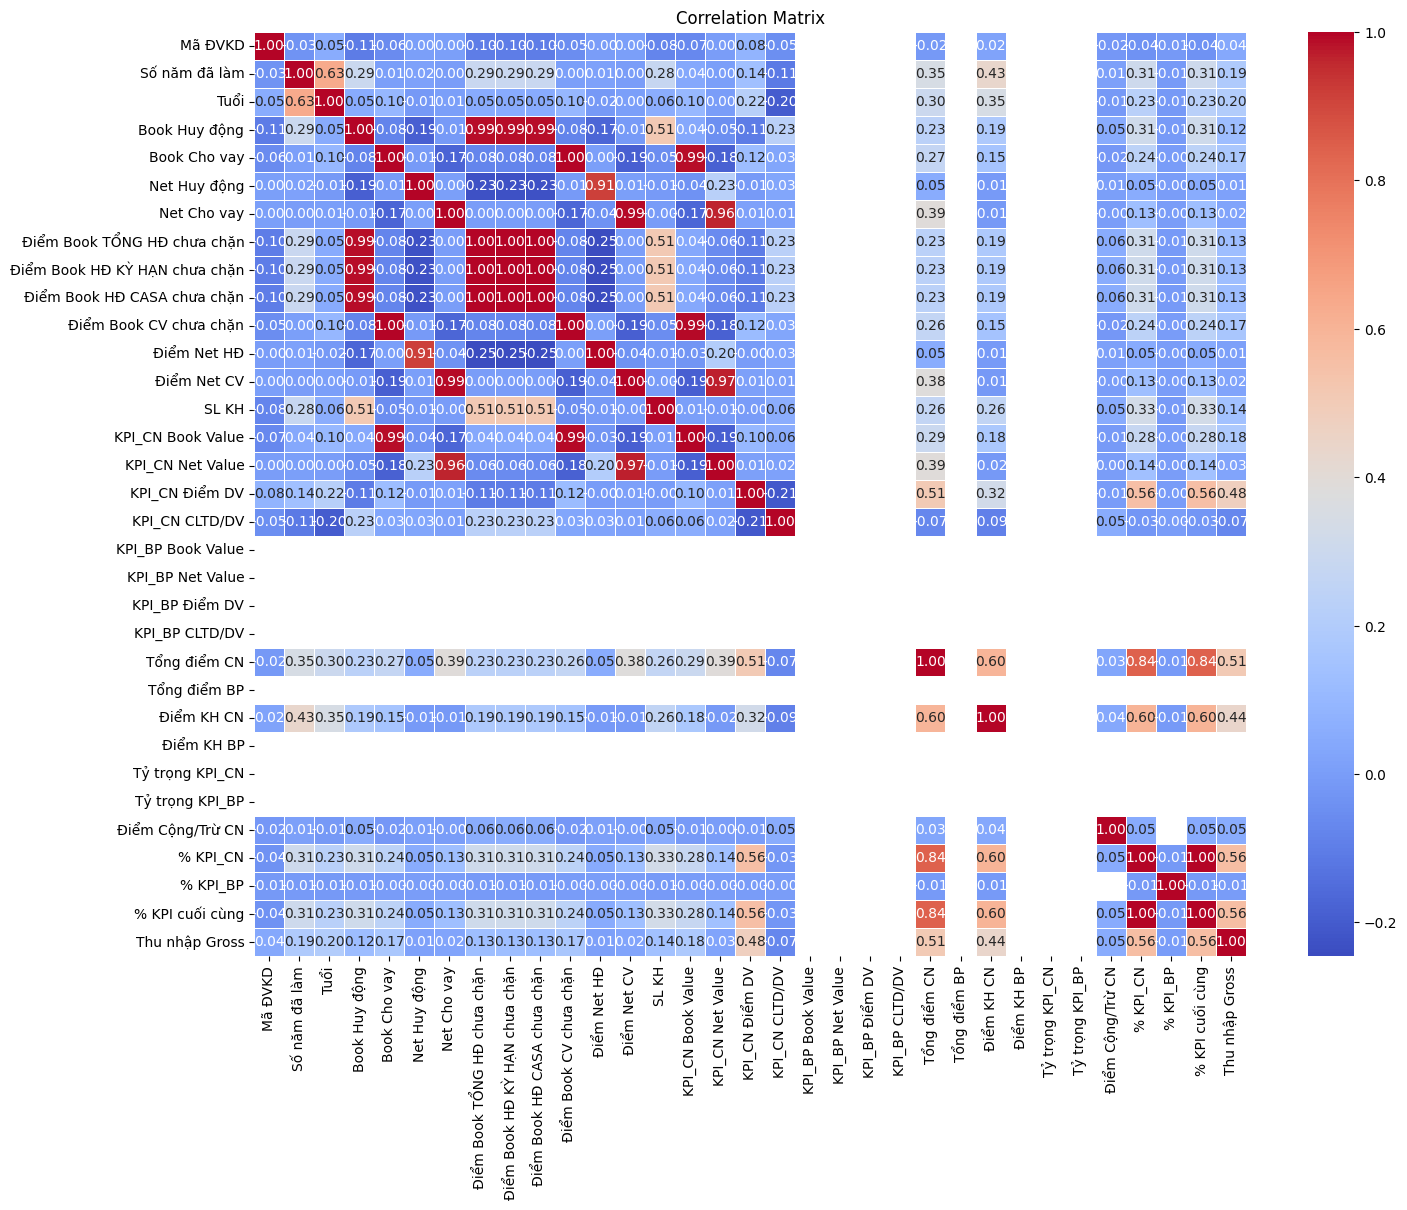

In [155]:
# Ma trận tương quan ban đầu
df_nv = dataframe_nv.select_dtypes(include=[np.number])
corr_matrix = df_nv.corr()
plt.figure(figsize=(16,12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [156]:
# Xóa các biến Không liên quan
df_nv.drop(columns=['Điểm Book TỔNG HĐ chưa chặn', 
                 'Điểm Book HĐ KỲ HẠN chưa chặn', 
                 'Điểm Book HĐ CASA chưa chặn', 
                 'Điểm Book CV chưa chặn',             
                 'Điểm Net HĐ',                         
                 'Điểm Net CV',                        
                 'KPI_CN Book Value',                   
                 'KPI_CN Net Value',  
                 'Tỷ trọng KPI_BP', 
                 'Tỷ trọng KPI_CN',
                 'KPI_BP Book Value',
                 'KPI_BP Net Value',
                 'KPI_BP Điểm DV',
                 'KPI_BP CLTD/DV',
                 'Điểm KH BP',
                 'Tổng điểm BP',
                 '% KPI_BP', 
                 'Mã ĐVKD',
                 'KPI_CN CLTD/DV',
                 'Net Huy động',
                 'Thu nhập Gross',
                 '% KPI_CN'    
                ], inplace=True)



# Xóa biến thiếu ý nghĩa - khoảng 90% giá trị = 0
df_nv.drop(columns=['Điểm Cộng/Trừ CN'], inplace=True)

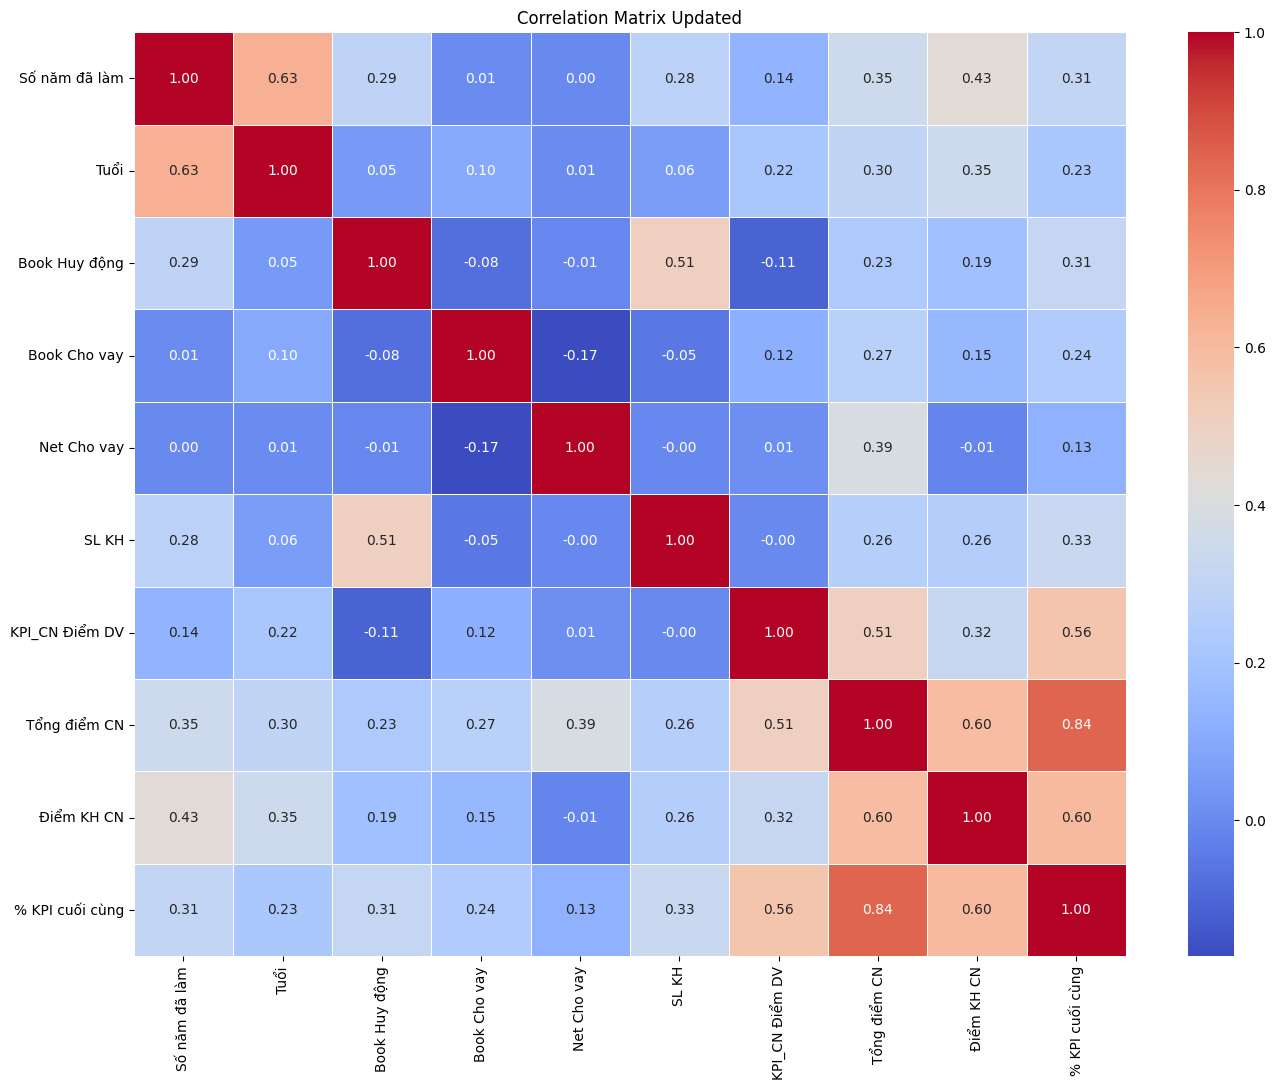

In [157]:
# Ma trận tương quan 2
df_numeric_2 = df_nv.select_dtypes(include=[np.number])
corr_matrix_2 = df_numeric_2.corr()
plt.figure(figsize=(16,12))
sns.heatmap(corr_matrix_2, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Updated')
plt.show()

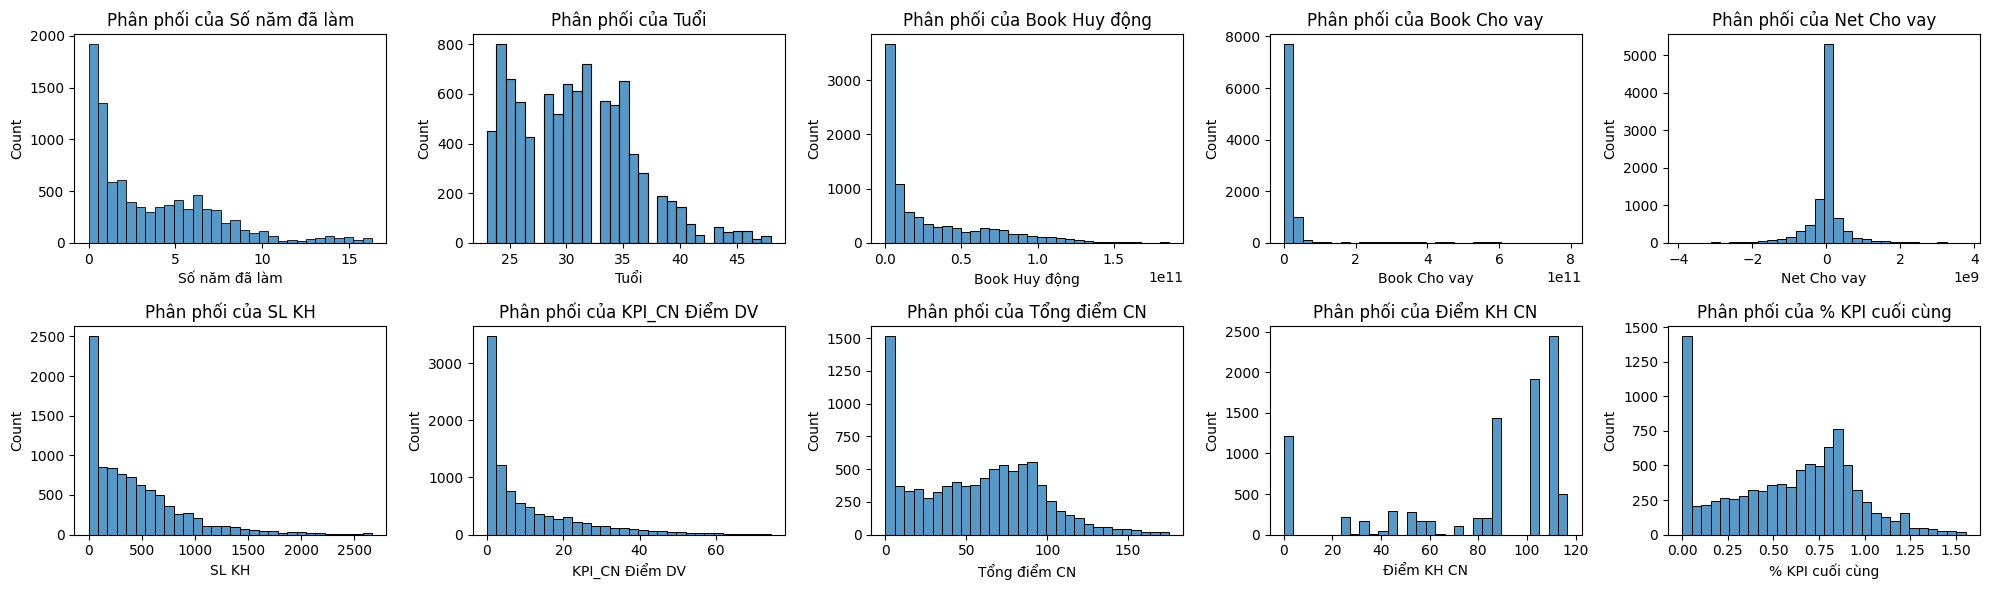

In [158]:
# Phân phối 
numerical_features = df_nv.select_dtypes(include=[np.number]).columns.tolist()
num_features = len(numerical_features)
cols = 5
rows = math.ceil(num_features / cols)
plt.figure(figsize=(cols * 4, rows * 3))

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(rows, cols, i)
    
    data_plt = df_nv[feature]                           # Tạo data_plt cắt đi phần ngoại lai trên dưới cho đồ thị mượt dễ hình dung hơn
    q_low = data_plt.quantile(0.01)
    q_high = data_plt.quantile(0.99)
    data_plt = data_plt[(data_plt >= q_low) & (data_plt <= q_high)]
    
    sns.histplot(data_plt, bins=30)
    plt.title(f'Phân phối của {feature}')
    plt.tight_layout()
plt.show()

# Standardize 3 datasets

# Standardize dataframe_nv


In [165]:
df_nv.tail(50)

,Số năm đã làm,Tuổi,Book Huy động,Book Cho vay,Net Cho vay,SL KH,KPI_CN Điểm DV,Tổng điểm CN,Điểm KH CN,% KPI cuối cùng
14009,0.08,35,"95,000,003.00",0.00,0.00,1,0.20,0.20,0.00,0.00
14010,0.08,23,0.00,0.00,0.00,0,0.00,0.00,0.00,0.00
14011,0.08,34,0.00,0.00,0.00,1,0.80,1.36,0.00,0.00
14012,0.08,25,0.00,0.00,0.00,0,0.00,0.00,0.00,0.00
14013,0.08,37,0.00,0.00,"220,412,903.23",3,0.00,0.70,0.00,0.00
14014,0.08,36,"8,923,697,183.00","8,376,502,255.20","-100,609,947.50",192,11.20,0.00,0.00,0.00
14015,0.08,26,"999,999.00",0.00,0.00,1,0.00,0.21,0.00,0.00
14016,0.08,27,0.00,0.00,0.00,0,0.00,0.00,0.00,0.00
14017,0.08,39,0.00,0.00,0.00,1,2.90,2.94,0.00,0.00
14018,0.08,32,"126,827,243.00","28,095,826,708.70","-145,762,544.31",81,13.35,0.00,0.00,0.00


# Classify the flexibility of Employee

# Divide dataset

In [160]:
# Biến x là các biến đầu vào, y là đầu ra cần dự đoán
x = df_nv.drop(['% KPI cuối cùng'], axis=1)   
y = df_nv['% KPI cuối cùng'] 

# Chia dữ liệu train/test
X_train, X_test, y_train, y_test = train_test_split(
    x, y, 
    test_size=0.2, 
    random_state=42               
)

# Kiểm tra kích thước tập train/test
print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (7501, 9)
Test size: (1876, 9)


In [161]:
# Sao chép dữ liệu gốc để xử lý riêng
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

In [162]:
# BIẾN ĐỊNH LƯỢNG
numerical_cols = X_train_scaled.select_dtypes(include=[np.number]).columns.tolist()

scaler = StandardScaler()
X_train_scaled[numerical_cols] = scaler.fit_transform(X_train_scaled[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test_scaled[numerical_cols])

# Kiểm tra
display(X_train_scaled.head(5))
print("")
display(X_train_scaled.describe())

,Số năm đã làm,Tuổi,Book Huy động,Book Cho vay,Net Cho vay,SL KH,KPI_CN Điểm DV,Tổng điểm CN,Điểm KH CN
12368,-0.91,-1.40,-0.43,-0.24,-0.00,0.27,0.50,-0.50,-1.40
11694,-0.63,-0.86,1.01,-0.24,-0.00,7.11,-0.48,0.39,0.17
7362,-0.78,-0.50,-0.45,-0.09,-0.02,-0.55,2.18,1.26,0.60
6203,-0.95,-1.22,-0.67,-0.25,-0.00,-0.85,-0.13,-1.13,-2.07
11648,0.23,-0.33,-0.51,0.03,-0.03,-0.17,-0.68,0.57,0.92


,Số năm đã làm,Tuổi,Book Huy động,Book Cho vay,Net Cho vay,SL KH,KPI_CN Điểm DV,Tổng điểm CN,Điểm KH CN
count,"7,501.00","7,501.00","7,501.00","7,501.00","7,501.00","7,501.00","7,501.00","7,501.00","7,501.00"
mean,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-0.98,-1.58,-0.67,-0.25,-24.11,-0.85,-1.17,-1.23,-2.07
25%,-0.80,-0.86,-0.63,-0.24,-0.01,-0.71,-0.62,-0.77,-0.63
50%,-0.35,-0.15,-0.42,-0.24,-0.00,-0.27,-0.39,0.00,0.55
75%,0.57,0.57,0.38,-0.12,-0.00,0.33,0.28,0.55,0.81
max,6.05,5.43,14.38,16.98,20.13,10.35,27.40,18.64,0.92


# Run the model

# Classification model

In [163]:
# Bước 1: Gán nhãn phân loại
def classify_kpi(kpi):
    if kpi < 0.5:
        return 'Kém'
    elif 0.5 <= kpi < 0.8:
        return 'Trung bình'
    elif 0.8 <= kpi < 1.0:
        return 'Tốt'
    elif 1.0 <= kpi <= 1.2:
        return 'Rất Tốt'
    else:
        return 'Xuất sắc'

# Gán nhãn cho tập train/test
y_train_label = y_train.apply(classify_kpi)
y_test_label = y_test.apply(classify_kpi)

# Encode nhãn thành số (để train được mô hình)
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_label)
y_test_encoded = label_encoder.transform(y_test_label)

# Kiểm tra nhãn
print("Classes:", label_encoder.classes_)
print("Encoded train labels:", np.unique(y_train_encoded, return_counts=True))


Classes: ['Kém' 'Rất Tốt' 'Trung bình' 'Tốt' 'Xuất sắc']
Encoded train labels: (array([0, 1, 2, 3, 4]), array([3019,  512, 2046, 1631,  293], dtype=int64))



================ Decision Tree ================

✅ Accuracy: 0.9883

📊 Classification Report:
              precision    recall  f1-score   support

         Kém       1.00      1.00      1.00       757
     Rất Tốt       0.97      0.99      0.98       134
  Trung bình       0.98      0.99      0.98       512
         Tốt       0.99      0.97      0.98       417
    Xuất sắc       1.00      1.00      1.00        56

    accuracy                           0.99      1876
   macro avg       0.99      0.99      0.99      1876
weighted avg       0.99      0.99      0.99      1876



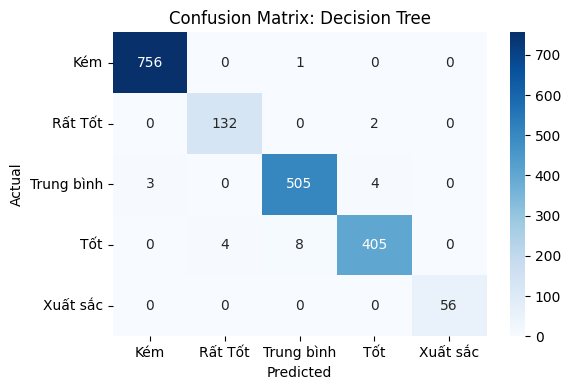


================ Random Forest ================

✅ Accuracy: 0.9771

📊 Classification Report:
              precision    recall  f1-score   support

         Kém       0.99      1.00      0.99       757
     Rất Tốt       0.93      0.96      0.94       134
  Trung bình       0.97      0.97      0.97       512
         Tốt       0.97      0.95      0.96       417
    Xuất sắc       0.98      1.00      0.99        56

    accuracy                           0.98      1876
   macro avg       0.97      0.98      0.97      1876
weighted avg       0.98      0.98      0.98      1876



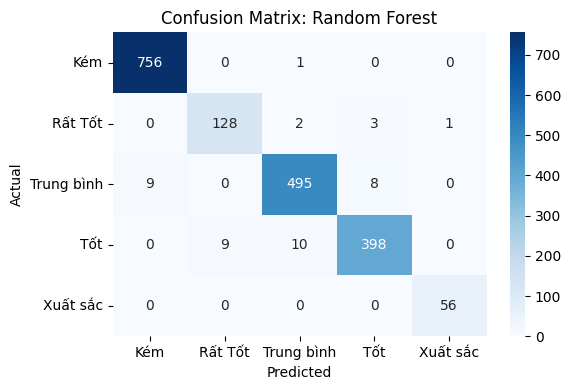


================ KNN ================

✅ Accuracy: 0.8523

📊 Classification Report:
              precision    recall  f1-score   support

         Kém       0.94      0.95      0.95       757
     Rất Tốt       0.72      0.54      0.62       134
  Trung bình       0.81      0.82      0.81       512
         Tốt       0.79      0.82      0.80       417
    Xuất sắc       0.81      0.82      0.81        56

    accuracy                           0.85      1876
   macro avg       0.81      0.79      0.80      1876
weighted avg       0.85      0.85      0.85      1876



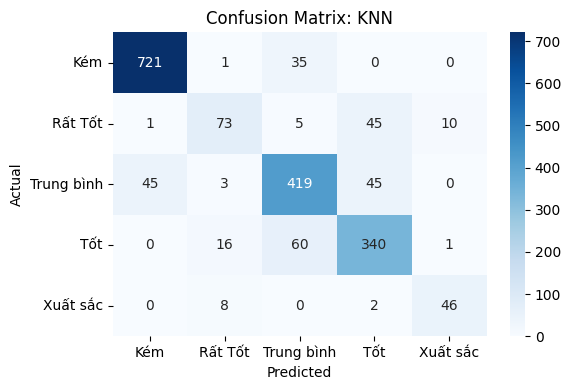


================ SVM ================

✅ Accuracy: 0.9216

📊 Classification Report:
              precision    recall  f1-score   support

         Kém       0.97      0.98      0.97       757
     Rất Tốt       0.90      0.67      0.77       134
  Trung bình       0.92      0.90      0.91       512
         Tốt       0.85      0.93      0.89       417
    Xuất sắc       0.91      0.89      0.90        56

    accuracy                           0.92      1876
   macro avg       0.91      0.87      0.89      1876
weighted avg       0.92      0.92      0.92      1876



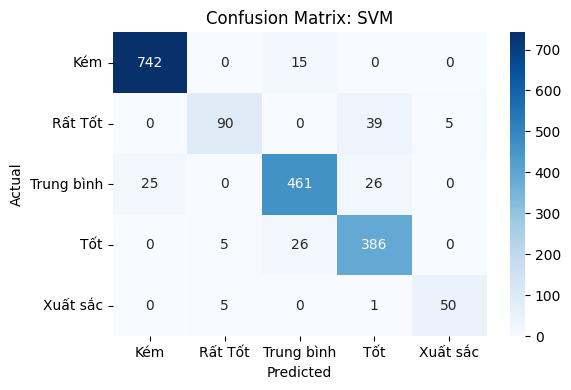


================ Gradient Boosting ================

✅ Accuracy: 0.9792

📊 Classification Report:
              precision    recall  f1-score   support

         Kém       0.99      1.00      0.99       757
     Rất Tốt       0.98      0.93      0.95       134
  Trung bình       0.98      0.97      0.97       512
         Tốt       0.97      0.97      0.97       417
    Xuất sắc       0.98      1.00      0.99        56

    accuracy                           0.98      1876
   macro avg       0.98      0.97      0.98      1876
weighted avg       0.98      0.98      0.98      1876



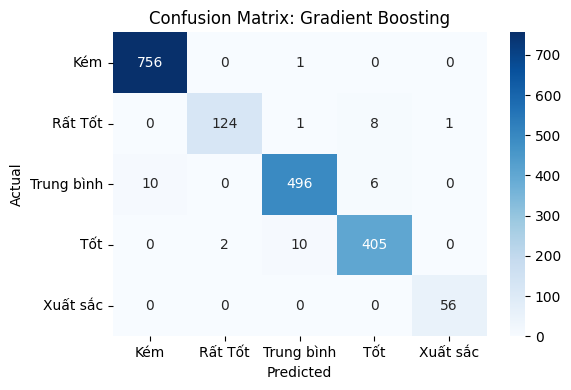


================ Logistic Regression ================

✅ Accuracy: 0.9152

📊 Classification Report:
              precision    recall  f1-score   support

         Kém       0.95      0.97      0.96       757
     Rất Tốt       0.85      0.61      0.71       134
  Trung bình       0.93      0.90      0.92       512
         Tốt       0.86      0.94      0.89       417
    Xuất sắc       0.94      0.84      0.89        56

    accuracy                           0.92      1876
   macro avg       0.90      0.85      0.87      1876
weighted avg       0.91      0.92      0.91      1876



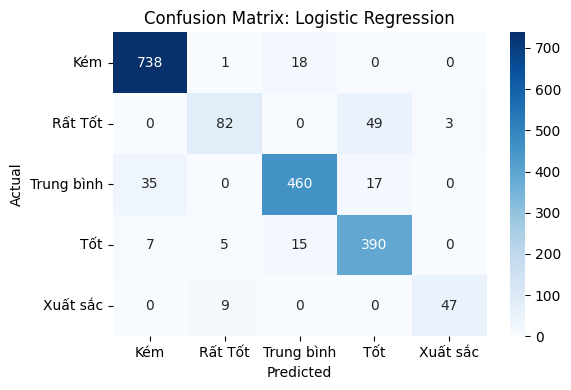

In [164]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Tập hợp các mô hình vào dictionary
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

# Huấn luyện và đánh giá từng mô hình
for name, model in models.items():
    print(f"\n================ {name} ================\n")
    
    # Huấn luyện
    model.fit(X_train_scaled, y_train_encoded)
    
    # Dự đoán
    y_pred = model.predict(X_test_scaled)

    # Accuracy
    acc = accuracy_score(y_test_encoded, y_pred)
    print(f"✅ Accuracy: {acc:.4f}\n")

    # Classification report
    print("📊 Classification Report:")
    print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

    # Confusion matrix
    cm = confusion_matrix(y_test_encoded, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()
